### News Data

In [ ]:
import pandas as pd
import seaborn as sns

In [32]:
df = pd.read_csv("gpt_snopes_with_facts.csv")
df.info()
print(df['Label'].sum())
df.drop('Label', axis= 1, inplace= True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2430 entries, 0 to 2429
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   DocText                       2430 non-null   object
 1   Label                         2430 non-null   int64 
 2   fake_news                     2427 non-null   object
 3   factual_content               2427 non-null   object
 4   counter_narrative_with_facts  2430 non-null   object
dtypes: int64(1), object(4)
memory usage: 95.1+ KB
2430


In [33]:
num_rows = 50

df = df.sample(num_rows)
df.head()

,DocText,fake_news,factual_content,counter_narrative_with_facts
785,Does This Photograph Show a Huge Blue Whale Un...,[\n 'A photograph shows a blue whale swimm...,"'Some versions of this image, such as a Reddit...",Counter-Narrative: Thank you for sharing this ...
1693,So You Think You Know the Real Donald Trump? A...,[\n 'Donald Trump sued the City of Palm Be...,"'But Trump didn't literally buy a ""segregated ...",Counter-Narrative: Thank you for sharing your ...
1284,Malia Obama Expelled from Harvard? Malia Obama...,[\n 'Malia Obama was expelled from Harvard...,'Malia Obama was not expelled from Harvard Uni...,Counter-Narrative: I understand that there has...
1536,Kanye West Wanted for Jewelry Insurance Scam M...,[\n 'Kanye West is wanted for questioning ...,"'The article published by Your News Wire, a we...",Counter-Narrative: I appreciate your engagemen...
338,St. Cloud Stabbing Victim Photographs show inj...,"[\n 'On 17 September, nine people were inj...",'According to the U.S. military newspaper Star...,Counter-Narrative: I appreciate your interest ...


In [4]:
# Load pre-trained LLM model and tokenizer (for paraphrasing)
# Appropriate choice required for proper usage
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load tokenizer and model

# For toxicity
model_name = "unitary/toxic-bert"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

c:\Users\anshu_r9i5971\Desktop\Python\NewsGan\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\anshu_r9i5971\Desktop\Python\NewsGan\.venv\Lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\anshu_r9i5971\.cache\huggingface\hub\models--unitary--toxic-bert. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an adm

In [ ]:
def get_toxicity_scores(texts, model):
    """
    Calculates toxicity scores for a list of texts using a T5-based toxicity model.

    Args:
        texts (list): A list of strings (texts) to analyze.
        model (str): The model.
    Returns:
        list: A list of toxicity scores (floats) corresponding to the input texts.
    """

    model.eval()  # Set the model to evaluation mode

    toxicity_scores = []
    with torch.no_grad():  # Disable gradient calculations for inference
        for text in texts:
            inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
            outputs = model(**inputs)
            probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)

            # Check
            # print(probabilities)

            toxicity_score = probabilities[0, 1].mean()  # Probability of the "toxic" class
            toxicity_scores.append(toxicity_score)

    return toxicity_scores

# Example usage:
texts = [
    "This is a friendly and positive message.",
    "You are a terrible person!",
    "Go jump off a bridge, you idiot.",
    
]

toxicity_scores = get_toxicity_scores(texts, model)

for text, score in zip(texts, toxicity_scores):
    print(f"Text: '{text}'")
    print(f"Toxicity Score: {score:.4f}")
    print("-" * 20)

tensor([[0.4047, 0.1037, 0.1445, 0.1049, 0.1328, 0.1094]])
tensor([[8.9513e-01, 1.7266e-04, 3.0163e-03, 9.6537e-05, 1.0129e-01, 2.9349e-04]])
tensor([[8.9086e-01, 4.4984e-04, 1.7806e-02, 8.2448e-05, 9.0724e-02, 7.9610e-05]])
Text: 'This is a friendly and positive message.'
Toxicity Score: 0.1037
--------------------
Text: 'You are a terrible person!'
Toxicity Score: 0.0002
--------------------
Text: 'Go jump off a bridge, you idiot.'
Toxicity Score: 0.0004
--------------------


In [34]:
data_df ={}
for col in df.columns:
    texts = df[col].to_list()
    data_df[col] = get_toxicity_scores(texts, model)

In [35]:
data_df = pd.DataFrame(data_df)
data_df.head()

,DocText,fake_news,factual_content,counter_narrative_with_facts
0,0.065173,0.051720,0.090987,0.094785
1,0.030340,0.013848,0.078422,0.103248
2,0.062702,0.045571,0.066947,0.104087
3,0.066084,0.095874,0.074039,0.099277
4,0.068014,0.054503,0.082488,0.104998


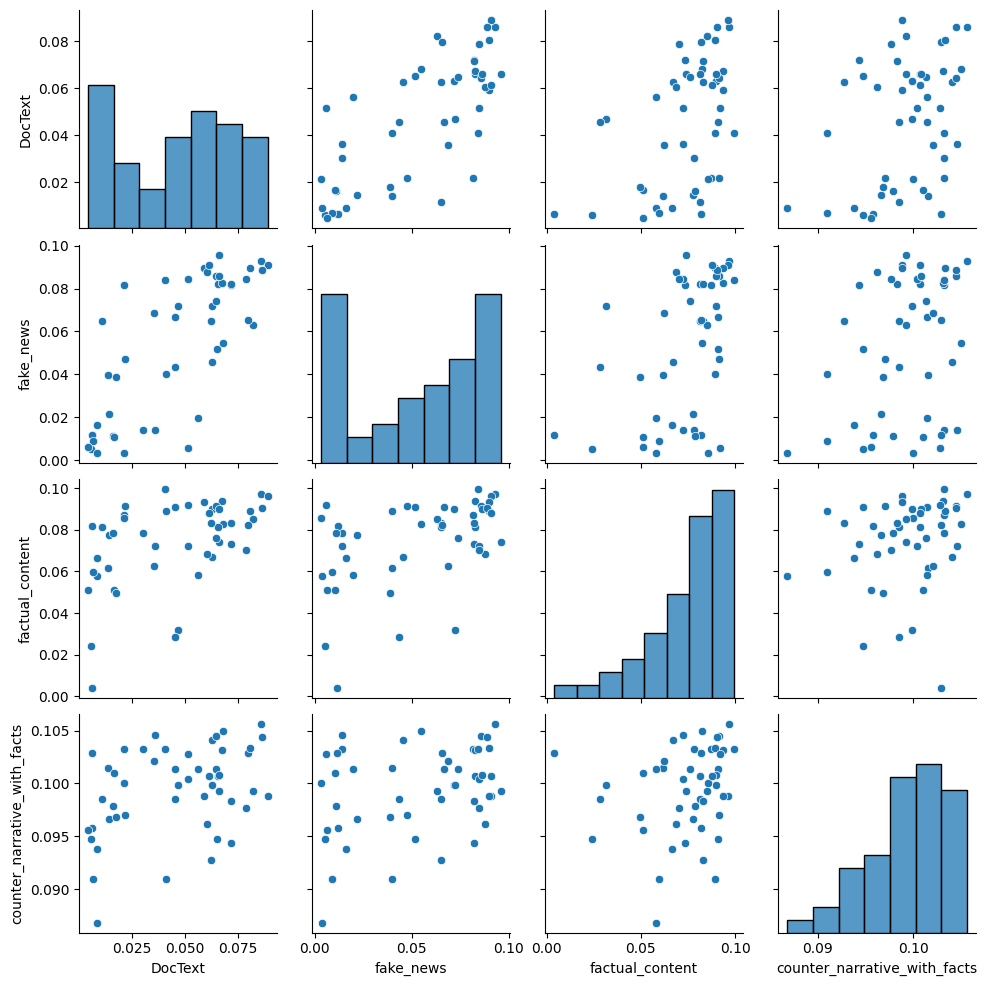

In [36]:
sns.pairplot(data= data_df)

In [ ]:
df.to_csv("file_with_scores.csv")